##  Build a machine learning model

In this activity, you will practice using tree-based modeling techniques to predict on a binary target class.
<br/>

**The purpose** of this model is to find factors that drive user churn.

**The goal** of this model is to predict whether or not a Waze user is retained or churned.
<br/>

### Imports and data loading

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,classification_report

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

#### Import the dataset

In [2]:
df=pd.read_csv('waze_dataset.csv')

In [3]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


### Feature engineering

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


#### **`km_per_driving_day`**

1. Create a feature representing the mean number of kilometers driven on each driving day in the last month for each user. Add this feature as a column to `df`.

2. Get descriptive statistics for this new feature

In [5]:
df['km_per_driving_day']=df['driven_km_drives']/df['driving_days']
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667


In [6]:
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Notice that some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

1. Convert these values from infinity to zero. You can use `np.inf` to refer to a value of infinity.

2. Call `describe()` on the `km_per_driving_day` column to verify that it worked.

In [7]:
df.loc[df['km_per_driving_day']==np.inf,'km_per_driving_day']=0

In [8]:
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**

1. Create a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use.

2. Get descriptive statistics for this new feature

In [9]:
df['percent_session_in_last_month']=df['sessions']/df['total_sessions']
df['percent_session_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_session_in_last_month, dtype: float64

#### **`professional_driver`**

Create a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers. In this scenario, domain knowledge and intuition are used to determine these deciding thresholds, but ultimately they are arbitrary.

To create this column, use the [`np.where()`](https://numpy.org/doc/stable/reference/generated/numpy.where.html) function. This function accepts as arguments:
1. A condition
2. What to return when the condition is true
3. What to return when the condition is false

```
Example:
x = [1, 2, 3]
x = np.where(x > 2, 100, 0)
x
array([  0,   0, 100])
```

In [10]:
df['professional_driver']=np.where((df['drives']>=60)&(df['driving_days']>15),1,0)
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_session_in_last_month,professional_driver
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1


#### **`total_sessions_per_day`**

Now, create a new column that represents the mean number of sessions per day _since onboarding_.

In [11]:
df['total_sessions_per_day']=df['total_sessions']/df['n_days_after_onboarding']

In [12]:
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**

Create a column representing the mean kilometers per hour driven in the last month.

In [13]:
df['km_per_hour']=df['driven_km_drives']/(df['duration_minutes_drives']/60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

#### **`km_per_drive`**

Create a column representing the mean number of kilometers per drive made in the last month for each user. Then, print descriptive statistics for the feature.

In [14]:
df['km_per_drive']=df['driven_km_drives']/df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [15]:
df.loc[df['km_per_drive']==np.inf,'km_per_drive']=0
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

Finally, create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places. Then, print descriptive statistics for the new column.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [16]:
df['percent_of_sessions_to_favorite']=(df['total_navigations_fav1']+df['total_navigations_fav2'])/df['total_sessions']
df['percent_of_sessions_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_sessions_to_favorite, dtype: float64

In [17]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_session_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363


###  Drop missing values

Because you know from previous EDA that there is no evidence of a non-random cause of the 700 missing values in the `label` column, and because these observations comprise less than 5% of the data, use the `dropna()` method to drop the rows that are missing this data.

In [18]:
df=df.dropna(subset='label')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14299 entries, 0 to 14998
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               14299 non-null  int64  
 1   label                            14299 non-null  object 
 2   sessions                         14299 non-null  int64  
 3   drives                           14299 non-null  int64  
 4   total_sessions                   14299 non-null  float64
 5   n_days_after_onboarding          14299 non-null  int64  
 6   total_navigations_fav1           14299 non-null  int64  
 7   total_navigations_fav2           14299 non-null  int64  
 8   driven_km_drives                 14299 non-null  float64
 9   duration_minutes_drives          14299 non-null  float64
 10  activity_days                    14299 non-null  int64  
 11  driving_days                     14299 non-null  int64  
 12  device            

###  Outliers

You know from previous EDA that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

###  Variable encoding

#### **Dummying features**

In order to use `device` as an X variable, you will need to convert it to binary, since this variable is categorical.

In cases where the data contains many categorical variables, you can use pandas built-in [`pd.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html), or you can use scikit-learn's [`OneHotEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) function.

**Note:** Each possible category of each feature will result in a feature for your model, which could lead to an inadequate ratio of features to observations and/or difficulty understanding your model's predictions.

Because this dataset only has one remaining categorical feature (`device`), it's not necessary to use one of these special functions. You can just implement the transformation directly.

Create a new, binary column called `device2` that encodes user devices as follows:

* `Android` -> `0`
* `iPhone` -> `1`

In [20]:
df['device2']=np.where(df['device']=='Android',0,1)
df[['device','device2']].head()

,device,device2
0,Android,0
1,iPhone,1
2,Android,0
3,iPhone,1
4,Android,0


#### **Target encoding**

The target variable is also categorical, since a user is labeled as either "churned" or "retained." Change the data type of the `label` column to be binary. This change is needed to train the models.

Assign a `0` for all `retained` users.

Assign a `1` for all `churned` users.

Save this variable as `label2` so as not to overwrite the original `label` variable.

**Note:** There are many ways to do this. Consider using `np.where()` as you did earlier in this notebook.

In [21]:
df['label2']=np.where(df['label']=='retained',0,1)
df[['label','label2']].head(10)

,label,label2
0,retained,0
1,retained,0
2,retained,0
3,retained,0
4,retained,0
5,retained,0
6,retained,0
7,retained,0
8,retained,0
9,churned,1


###  Feature selection

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.

Note, however, that `device` won't be used simply because it's a copy of `device2`.

Drop `ID` from the `df` dataframe.

In [22]:
df=df.drop('ID',axis=1)

In [23]:
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_session_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite,device2,label2
0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931,0,0
1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903,1,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640,1,0
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363,0,0


###  Evaluation metric

Before modeling, you must decide on an evaluation metric. This will depend on the class balance of the target variable and the use case of the model.

First, examine the class balance of your target variable.

In [24]:
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

Now, consider which evaluation metric is best. Remember, accuracy might not be the best gauge of performance because a model can have high accuracy on an imbalanced dataset and still fail to predict the minority class.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, select the model based on the recall score.

### Modeling workflow and model selection process

The final modeling dataset contains 14,299 samples. This is towards the lower end of what might be considered sufficient to conduct a robust model selection process, but still doable.

1. Split the data into train/validation/test sets (60/20/20)

Note that, when deciding the split ratio and whether or not to use a validation set to select a champion model, consider both how many samples will be in each data partition, and how many examples of the minority class each would therefore contain. In this case, a 60/20/20 split would result in \~2,860 samples in the validation set and the same number in the test set, of which \~18%&mdash;or 515 samples&mdash;would represent users who churn.

2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)

###  Split the data

Now you're ready to model. The only remaining step is to split the data into features/target variable and training/validation/test sets.

1. Define a variable `X` that isolates the features. Remember not to use `device`.

2. Define a variable `y` that isolates the target variable (`label2`).

3. Split the data 80/20 into an interim training set and a test set. Don't forget to stratify the splits, and set the random state to 42.

4. Split the interim training set 75/25 into a training set and a validation set, yielding a final ratio of 60/20/20 for training/validation/test sets. Again, don't forget to stratify the splits and set the random state.

In [25]:
# Input variables
x=df.drop(columns=['label','label2','device'])
# target variables
y=df['label2']
# split into train and test datasets
x_tr,x_test,y_tr,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=42)
# split into train and validation datasets
x_train,x_val,y_train,y_val=train_test_split(x_tr,y_tr,stratify=y_tr,test_size=0.25,random_state=42)

In [26]:
x_test.shape

(2860, 18)

In [27]:
x_val.shape

(2860, 18)

In [28]:
x_train.shape

(8579, 18)

###  Modeling

#### **Random forest**

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take.
 - `max_depth`
 - `max_features`
 - `max_samples`
 - `min_samples_leaf`
 - `min_samples_split`
 - `n_estimators`

3. Define a set `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf_cv`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)

 `refit` should be set to `'recall'`.<font/>

In [29]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

Now fit the model to the training data.

In [30]:
%%time
rf_cv.fit(x_train,y_train)

CPU times: total: 1min 53s
Wall time: 2min 45s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring={'recall', 'f1', 'accuracy', 'precision'})

Examine the best average score across all the validation folds.

In [31]:
rf_cv.best_score_

0.12678201409034398

Examine the best combination of hyperparameters.

In [32]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [33]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

Pass the `GridSearch` object to the `make_results()` function.

In [34]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.45726,0.126782,0.198447,0.81851


Asside from the accuracy, the scores aren't that good. However, recall that when you built the logistic regression model in the last the recall was \~0.09, which means that this model has 33% better recall and about the same accuracy, and it was trained on less data.

If you want, feel free to try retuning your hyperparameters to try to get a better score. You might be able to marginally improve the model.

#### **XGBoost**
​
 Try to improve your scores using an XGBoost model.
​
1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.
​
2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`
​
3. Define a set `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).
​
4. Instantiate the `GridSearchCV` object `xgb_cv`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='recall'`)

In [35]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

Now fit the model to the `X_train` and `y_train` data.

Note this cell might take several minutes to run.

In [36]:
%%time
xgb_cv.fit(x_train, y_train)

CPU times: total: 6min 9s
Wall time: 34.8 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'recall', 'f1', 'accuracy', 'precision'})

Get the best score from this model.

In [37]:
xgb_cv.best_score_

0.18003349910208594

Get the best parameters

In [38]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [39]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457260,0.126782,0.198447,0.818510
0,XGB cv,0.442149,0.180033,0.255812,0.814198


This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous course, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

###  Model selection

Now, use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

#### **Random forest**

In [40]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(x_val)

Use the `get_test_scores()` function to generate a table of scores from the predictions on the validation data.

In [41]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [42]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457260,0.126782,0.198447,0.818510
0,XGB cv,0.442149,0.180033,0.255812,0.814198
0,RF val,0.438849,0.120316,0.188854,0.816783


Notice that the scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

#### **XGBoost**

Now, do the same thing to get the performance scores of the XGBoost model on the validation data.

In [43]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(x_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457260,0.126782,0.198447,0.818510
0,XGB cv,0.442149,0.180033,0.255812,0.814198
0,RF val,0.438849,0.120316,0.188854,0.816783
0,XGB val,0.392670,0.147929,0.214900,0.808392


Just like with the random forest model, the XGBoost model's validation scores were lower, but only very slightly. It is still the clear champion.

### Use champion model to predict on test data

Now, use the champion model to predict on the test dataset. This is to give a final indication of how you should expect the model to perform on new future data, should you decide to use the model.

In [44]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(x_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457260,0.126782,0.198447,0.818510
0,XGB cv,0.442149,0.180033,0.255812,0.814198
0,RF val,0.438849,0.120316,0.188854,0.816783
0,XGB val,0.392670,0.147929,0.214900,0.808392
0,XGB test,0.421569,0.169625,0.241913,0.811538


The recall was exactly the same as it was on the validation data, but the precision declined notably, which caused all of the other scores to drop slightly. Nonetheless, this is stil within the acceptable range for performance discrepancy between validation and test scores.

### Confusion matrix

Plot a confusion matrix of the champion model's predictions on the test data.

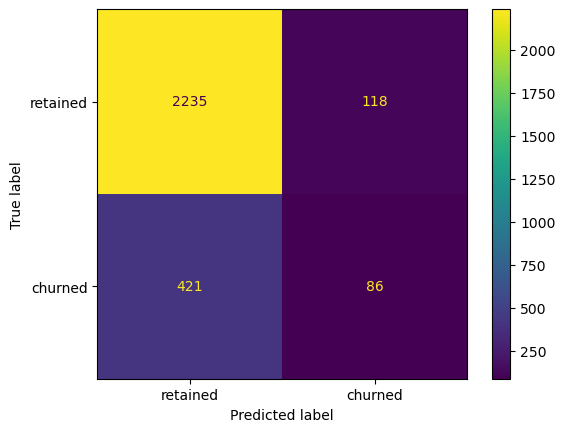

In [45]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

In [46]:
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, xgb_test_preds, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.84      0.95      0.89      2353
    Predicted would leave       0.42      0.17      0.24       507

                 accuracy                           0.81      2860
                macro avg       0.63      0.56      0.57      2860
             weighted avg       0.77      0.81      0.78      2860



In [47]:
from collections import Counter
import numpy as np

# Assuming y_pred is your predicted labels array# Your predicted labels array

# Count occurrences of each unique element in y_pred
counts = Counter(y_test)

# Convert the result to a dictionary
counts_dict = dict(counts)

# Print the counts of unique elements
print(counts_dict)

{0: 2353, 1: 507}


In [48]:
from collections import Counter
import numpy as np

# Assuming y_pred is your predicted labels array# Your predicted labels array

# Count occurrences of each unique element in y_pred
counts = Counter(xgb_test_preds)

# Convert the result to a dictionary
counts_dict = dict(counts)

# Print the counts of unique elements
print(counts_dict)

{0: 2656, 1: 204}


In [49]:
from collections import Counter
import numpy as np

# Assuming y_pred is your predicted labels array# Your predicted labels array

# Count occurrences of each unique element in y_pred
counts = Counter(rf_val_preds)

# Convert the result to a dictionary
counts_dict = dict(counts)

# Print the counts of unique elements
print(counts_dict)

{0: 2721, 1: 139}


###  Feature importance

Use the `plot_importance` function to inspect the most important features of your final model.

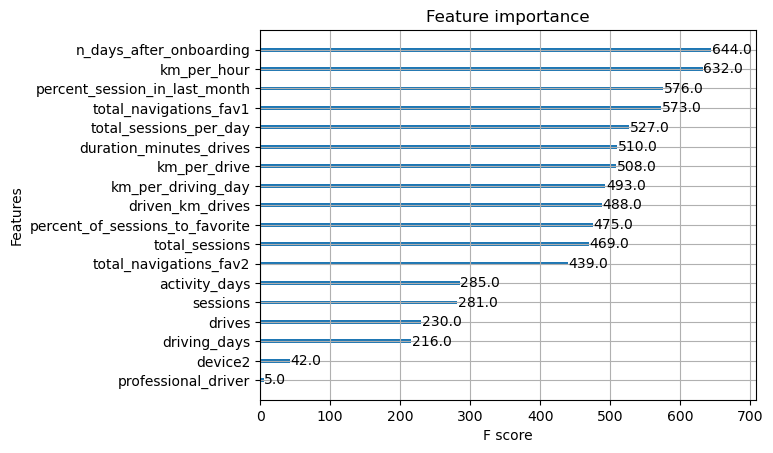

In [50]:
plot_importance(xgb_cv.best_estimator_);

In [51]:
data={'sessions':[73,50,13,60,42,243,149,73],'drives':[61,41,11,55,35,219,120,58],'total_sessions':[329.904300,102.444592,41.804981,207.875622,187.670313,422.017241,180.524184,353.419797],'n_days_after_onboarding':[614,1463,770,140,2505,1873,3150,3383],'total_navigations_fav1':[60,0,132,317,15,17,45,13],'total_navigations_fav2':[46,121,87,0,10,0,0,51],'driven_km_drives':[6090.450154,4094.536313,1533.521450,2890.496901,4062.575194,3097.825028,4051.758549,6030.498773],'duration_minutes_drives':[3323.880771,2201.984210,823.418616,2186.155708,1208.583193,1031.278706,254.187763,3042.436423],'activity_days':[0,4,0,25,25,18,6,14],'driving_days':[0,2,0,17,20,17,6,13],'km_per_driving_day':[0.000000,2047.268157,0.000000,170.029229,203.128760,182.225002,675.293092,463.884521],'percent_session_in_last_month':[0.221276,0.488069,0.310968,0.288634,0.223797,0.646893,0.825374,0.206553],'professional_driver':[0,0,0,0,0,1,0,0],'total_sessions_per_day':[0.537303,0.070024,0.054292,1.484826,0.074918,0.225316,0.057309,0.104469],'km_per_hour':[109.939867,111.568547,111.743025,79.330952,201.686167,180.232076,956.401322,118.927687],'km_per_drive':[99.843445,99.866739,139.411041,52.554489,116.073577,14.145320,33.764655,103.974117],'percent_of_sessions_to_favorite':[0.321305,1.181126,5.238610,1.524950,0.133212,0.040283,0.249274,0.181088],'device2':[0,1,0,1,0,1,1,1]}

In [52]:
data=pd.DataFrame(data)
data

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_session_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite,device2
0,73,61,329.904300,614,60,46,6090.450154,3323.880771,0,0,0.000000,0.221276,0,0.537303,109.939867,99.843445,0.321305,0
1,50,41,102.444592,1463,0,121,4094.536313,2201.984210,4,2,2047.268157,0.488069,0,0.070024,111.568547,99.866739,1.181126,1
2,13,11,41.804981,770,132,87,1533.521450,823.418616,0,0,0.000000,0.310968,0,0.054292,111.743025,139.411041,5.238610,0
3,60,55,207.875622,140,317,0,2890.496901,2186.155708,25,17,170.029229,0.288634,0,1.484826,79.330952,52.554489,1.524950,1
4,42,35,187.670313,2505,15,10,4062.575194,1208.583193,25,20,203.128760,0.223797,0,0.074918,201.686167,116.073577,0.133212,0
5,243,219,422.017241,1873,17,0,3097.825028,1031.278706,18,17,182.225002,0.646893,1,0.225316,180.232076,14.145320,0.040283,1
6,149,120,180.524184,3150,45,0,4051.758549,254.187763,6,6,675.293092,0.825374,0,0.057309,956.401322,33.764655,0.249274,1
7,73,58,353.419797,3383,13,51,6030.498773,3042.436423,14,13,463.884521,0.206553,0,0.104469,118.927687,103.974117,0.181088,1


In [53]:
op=xgb_cv.best_estimator_.predict(data)
op

array([1, 1, 1, 0, 0, 0, 1, 0])

In [54]:
from collections import Counter
import numpy as np

  # Your predicted labels array

# Count occurrences of each unique element in y_pred
counts = Counter(op)

# Convert the result to a dictionary
counts_dict = dict(counts)

# Print the counts of unique elements
print(counts_dict)


{1: 4, 0: 4}
